In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()
# Chọn file kaggle.json tải về ở bước 2 để tải lên

!mkdir '/root/.kaggle'
!cp kaggle.json '/root/.kaggle'
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list
# Chạy lệnh liệt kê các bộ dữ liệu của bạn để đảm bảo bạn đã cài đặt thành công

In [ ]:
!kaggle datasets download -d pybear/cats-vs-dogs

100% 785M/788M [00:04<00:00, 179MB/s]
100% 788M/788M [00:04<00:00, 172MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from tensorflow.keras.utils import load_img
warnings.filterwarnings('ignore')

In [ ]:
!unzip /content/cats-vs-dogs.zip

In [ ]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages/Cat/6738.jpg 0


In [ ]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

images  label
0   PetImages/Dog/7520.jpg      1
1  PetImages/Dog/10020.jpg      1
2   PetImages/Dog/7827.jpg      1
3   PetImages/Cat/7421.jpg      0
4   PetImages/Cat/6996.jpg      0

In [ ]:
for i in df['images']:
    if '.jpg' not in i:
        print(i)

PetImages/Dog/Thumbs.db
PetImages/Cat/Thumbs.db


In [ ]:
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

['PetImages/Dog/Thumbs.db',
 'PetImages/Dog/11702.jpg',
 'PetImages/Cat/Thumbs.db',
 'PetImages/Cat/666.jpg']

In [ ]:
# delete db files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
len(df)

24998

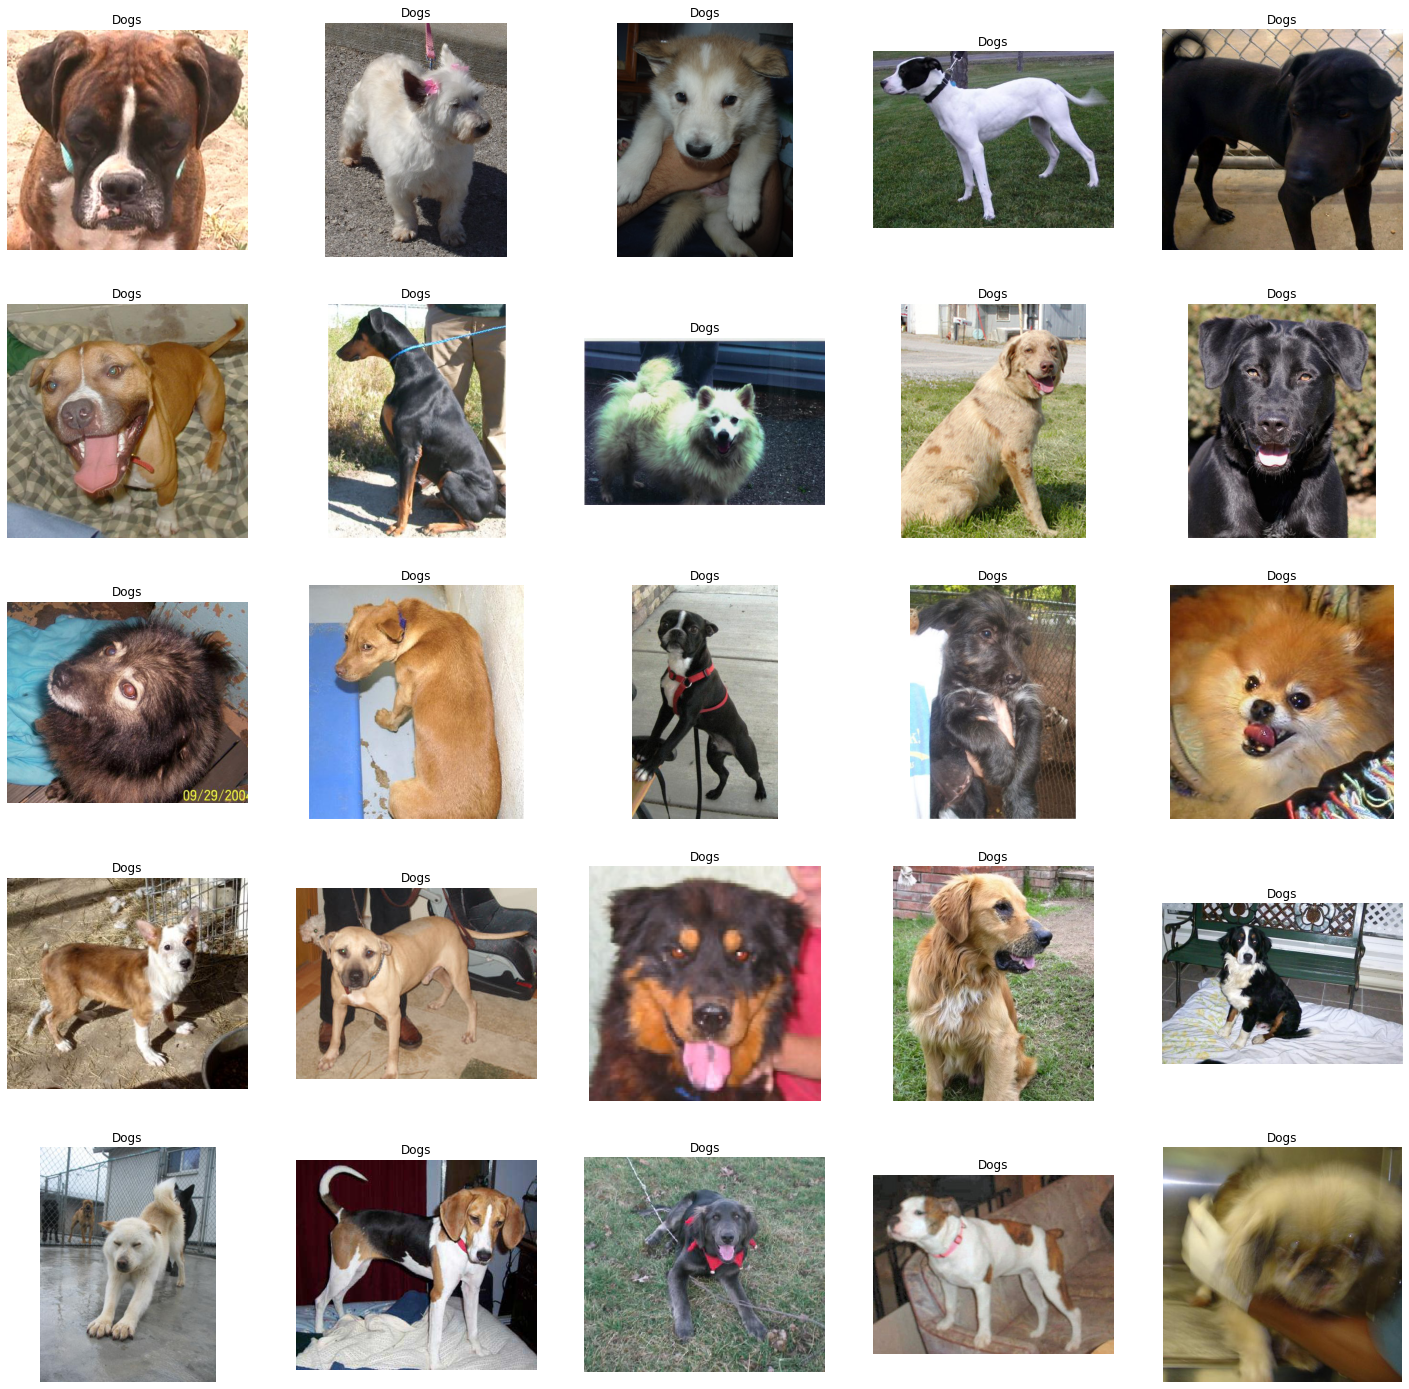

In [ ]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

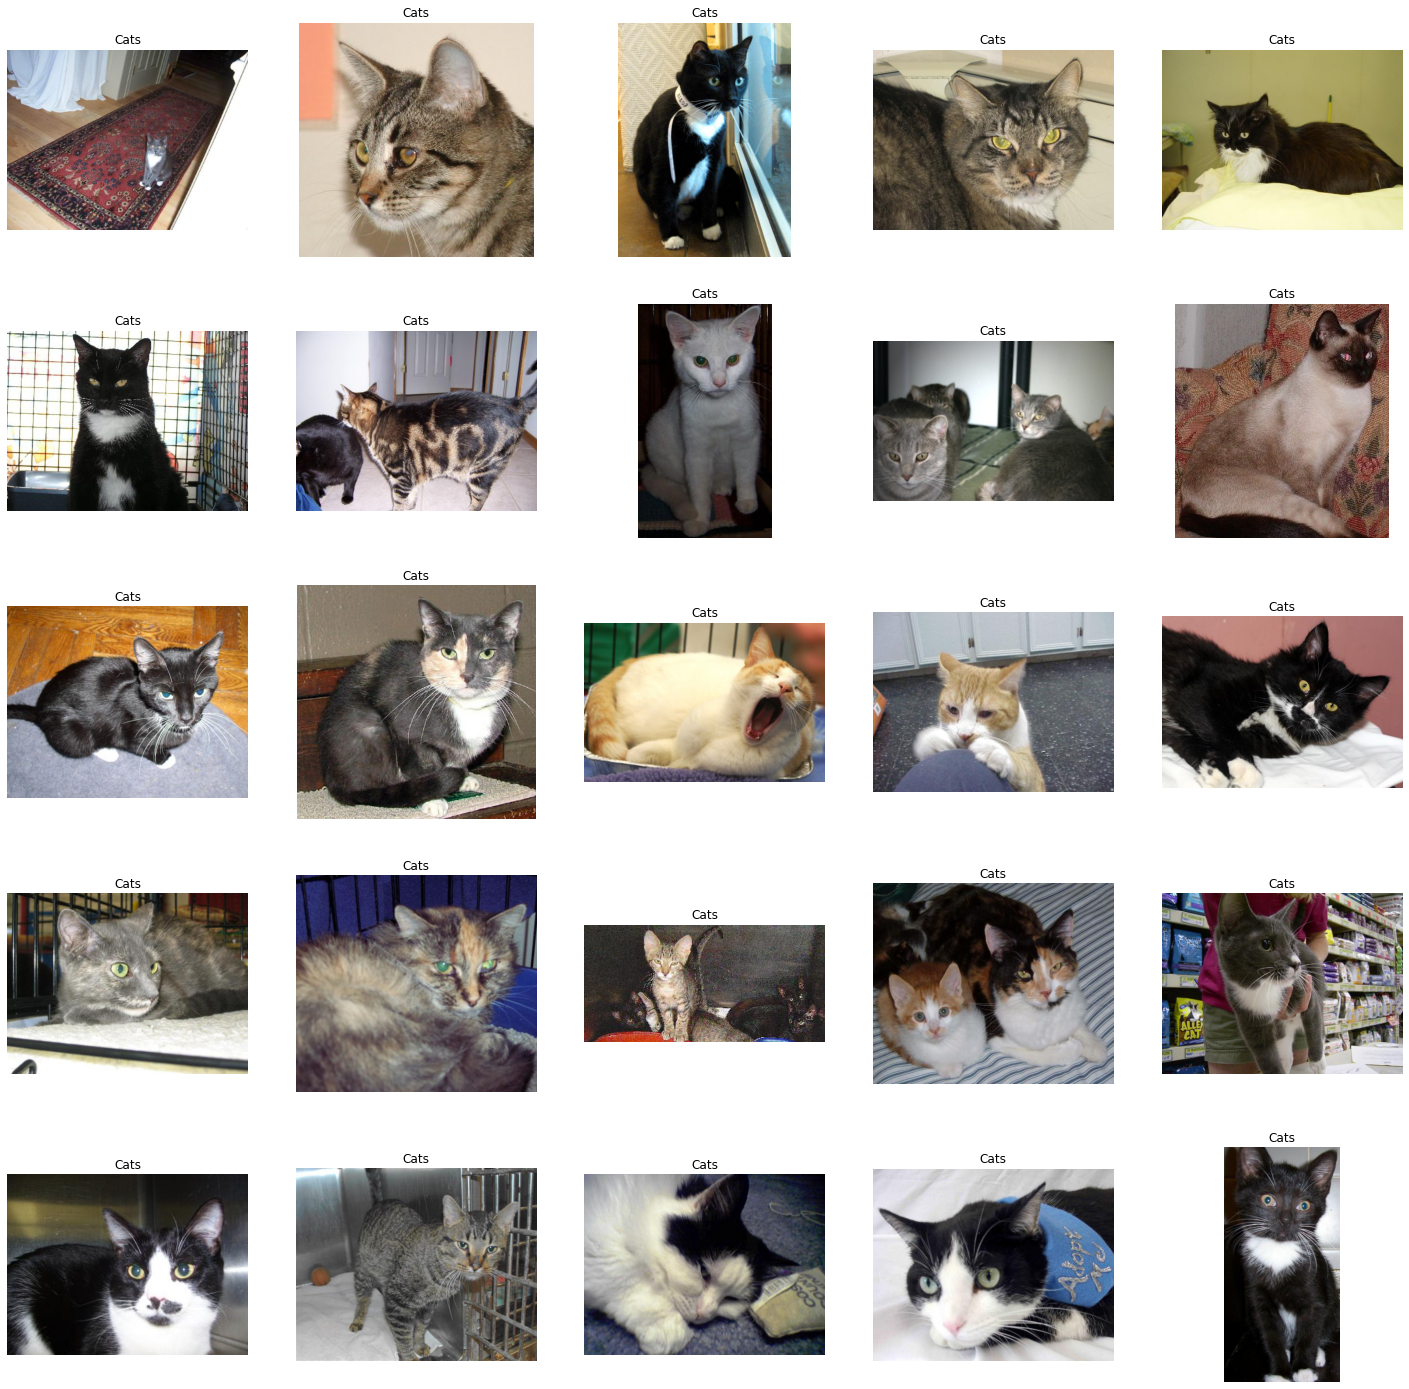

In [ ]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

<AxesSubplot:xlabel='label', ylabel='count'>

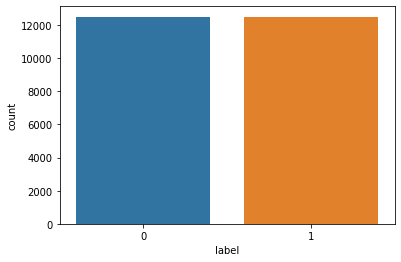

In [ ]:
import seaborn as sns
sns.countplot(df['label'])

Create data generation for the image

In [ ]:
df['label'] = df['label'].astype('str')
df.head()

images label
0   PetImages/Dog/7520.jpg     1
1  PetImages/Dog/10020.jpg     1
2   PetImages/Dog/7827.jpg     1
3   PetImages/Cat/7421.jpg     0
4   PetImages/Cat/6996.jpg     0

In [ ]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Model Creation

In [ ]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [ ]:
a = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
40/40 [==============================] - 174s 4s/step - loss: 0.7215 - accuracy: 0.5428 - val_loss: 0.6951 - val_accuracy: 0.5720
Epoch 2/10
40/40 [==============================] - 145s 4s/step - loss: 0.6262 - accuracy: 0.6501 - val_loss: 0.5884 - val_accuracy: 0.6884
Epoch 3/10
40/40 [==============================] - 146s 4s/step - loss: 0.5731 - accuracy: 0.7000 - val_loss: 0.5474 - val_accuracy: 0.7280
Epoch 4/10
40/40 [==============================] - 145s 4s/step - loss: 0.5681 - accuracy: 0.7001 - val_loss: 0.5581 - val_accuracy: 0.7158
Epoch 5/10
40/40 [==============================] - 144s 4s/step - loss: 0.5338 - accuracy: 0.7314 - val_loss: 0.5071 - val_accuracy: 0.7490
Epoch 6/10
40/40 [==============================] - 143s 4s/step - loss: 0.5216 - accuracy: 0.7434 - val_loss: 0.5020 - val_accuracy: 0.7518
Epoch 7/10
40/40 [==============================] - 145s 4s/step - loss: 0.5017 - accuracy: 0.7556 - val_loss: 0.4981 - val_accuracy: 0.7536
Epoch 8/10
40

Visualization

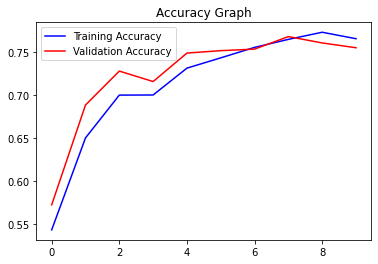

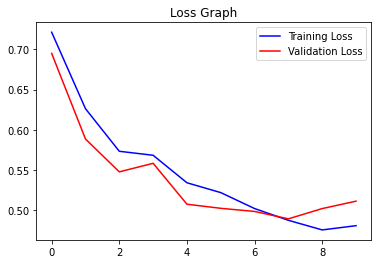

In [ ]:
acc = a.history['accuracy']
val_acc = a.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = a.history['loss']
val_loss = a.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()